In [23]:
from pathlib import Path
import time
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import timm
import data

## Models EDA

In [12]:
model = timm.create_model('tf_mobilenetv3_small_minimal_100', num_classes=2, pretrained=False)

In [ ]:
model

In [10]:
model = torchvision.models.shufflenet_v2_x1_0(pretrained=False)

In [ ]:
model

In [14]:
# for each model different method for changing ouput layer
# model.classifier[1] = nn.Linear(1280, 1)
# model.fc = nn.Linear(1024, 1)
# model.classifier[1] = nn.Conv2d(512, 1, kernel_size=1)

### Speed test for different models

In [15]:
def bench(model, input_size=160, n=100):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for i in range(n):
            model(torch.rand(1, 3, input_size, input_size))
    return f'{(time.time() - start) / n:.3f} ms'

In [16]:
bench(model)

'0.006 ms'

### Check for disk space in fp16

In [18]:
torch.save(model.half().state_dict(), 'model.pth')

### Results

- squeezenet1_1: 1.4Mb, 9ms
- mnasnet0_5: 1.9Mb, 9ms
- mobilenetv3_small_minimal_100: 2.1Mb, 6ms
- shufflenet_v2_x1_0: 2.5Mb, 12ms
- mobilenetv3_small_100: 3Mb, 10ms
- mobilenet_v2: 4.4Mb, 14ms
- efficientnet_lite0: 6.6Mb, 16ms

## Data EDA

In [19]:
data_root = Path('/data')
dataset_folder = data_root / 'img_align_celeba'

In [20]:
img_path = list(dataset_folder.iterdir())[3]

In [21]:
img = Image.open(img_path)
img.size

(178, 218)

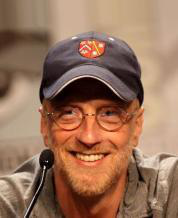

In [22]:
img

### Image augmentations

In [25]:
IMAGENET_STATS = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
crop_size = 160

In [26]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(degrees=(0, 0), translate=(0.1, 0.1), scale=(0.9, 1.2)),
        transforms.RandomChoice([
            transforms.RandomAffine(degrees=(-30, 30)),
            transforms.RandomAffine(degrees=(0, 0), shear=(-10, 10, -10, 10))
        ]),
        
        transforms.RandomChoice([
            transforms.ColorJitter(hue=0.04, saturation=0.5),
            transforms.ColorJitter(contrast=0.3, brightness=0.3),
        ]),

        transforms.RandomCrop(crop_size),
        transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(IMAGENET_STATS)
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(crop_size),
#         transforms.ToTensor(),
#         transforms.Normalize(IMAGENET_STATS)
    ]),
}

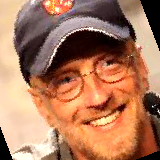

In [35]:
data_transforms['train'](img)

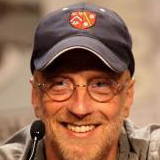

In [36]:
data_transforms['val'](img)